## Imports

In [1]:
from pandas_datareader import data as pdr 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper,Series
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.gofplots import qqplot 
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.model_selection import train_test_split
from random import gauss,seed
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.arima_model import ARIMA 
import pmdarima as pm 


## Load Data

In [2]:
data = pd.read_csv("drug_sales_australia.csv")
data["date"] = pd.to_datetime(data["date"])
data.set_index("date",inplace=True)

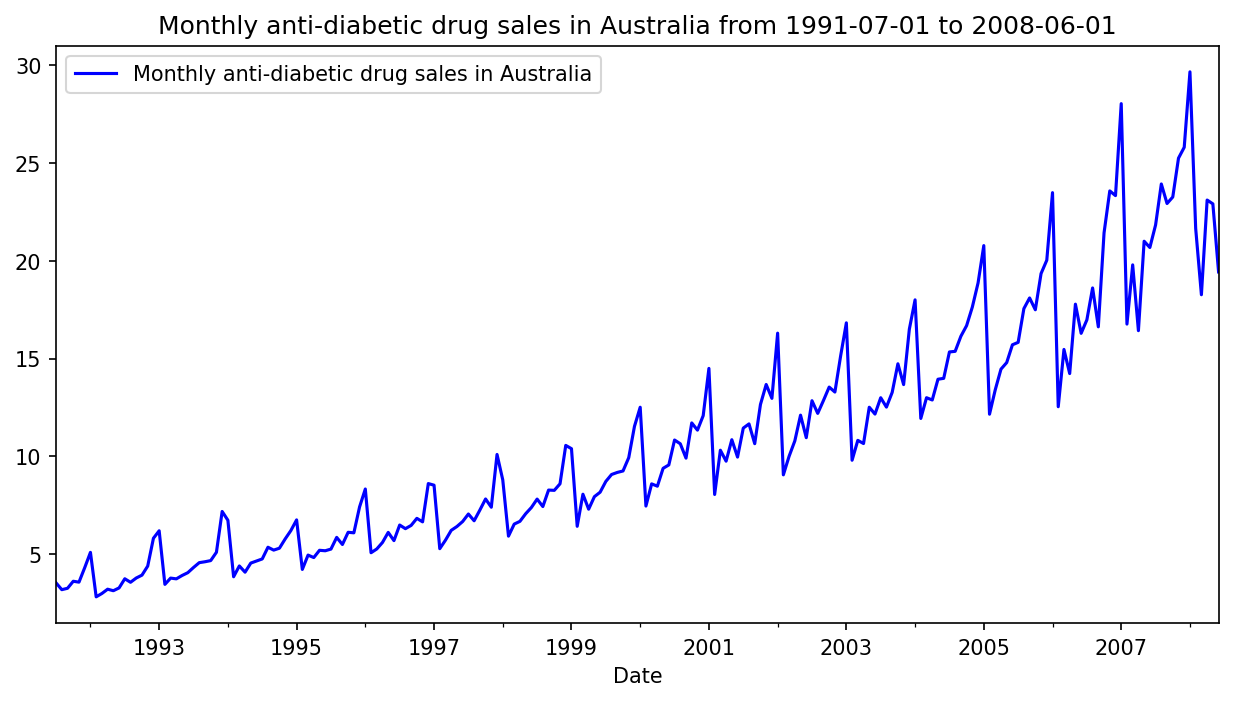

In [3]:

plt.figure(figsize=(10, 5), dpi=150) #dpi = resolution. default 100.
data['value'].plot(label='Monthly anti-diabetic drug sales in Australia', color='blue')
plt.title('Monthly anti-diabetic drug sales in Australia from {} to {}'.format('1991-07-01', '2008-06-01'))
plt.xlabel('Date')
plt.legend()


## Process Data

In [4]:
def get_train_test_split(df,train_end_date,test_start_date,test_end_date):
    temp_df = df.copy()
    train_data = temp_df[:train_end_date]
    test_data = temp_df[test_start_date:test_end_date]
    test_data.rename(columns={"value": "Test"},inplace = True)
    print("IP:",train_end_date,"::",test_start_date,"to",test_end_date, end = " ")
    print("Train:",train_data.index.min(),train_data.index.max(), end = " ")
    print("Test:",test_data.index.min(),test_data.index.max(), end = " ")
    print()
    return train_data,test_data

In [5]:
# Find the indexes that are missing
pd.date_range(start = data.index.min(), end = data.index.max(), freq='MS').difference(data.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='MS')

In [6]:
def plot_ts(df,plot_col = "", ax = "",title = "Time Series Plot"):
    sns.lineplot(x=df.index, y=df[plot_col], ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel(plot_col)
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)
    return ax

In [7]:
test_time_periods = [["2004-06","2004-07","2005-06"],["2005-06","2005-07","2006-06"],["2006-06","2006-07","2007-06"],["2007-06","2007-07","2008-06"]]

# Back test 12 month forecasts over 4 test periods - July 2004-June 2005, July 2005-June 2006,  July 2006-June 2007, July 2007-June 2008 

jul2004tojun2005_train, jul2004tojun2005_test = get_train_test_split(data,test_time_periods[0][0],test_time_periods[0][1],test_time_periods[0][-1])
jul2005tojun2006_train, jul2005tojun2006_test = get_train_test_split(data,test_time_periods[1][0],test_time_periods[1][1],test_time_periods[1][-1])
jul2006tojun2007_train, jul2006tojun2007_test = get_train_test_split(data,test_time_periods[2][0],test_time_periods[2][1],test_time_periods[2][-1])
jul2007tojun2008_train, jul2007tojun2008_test = get_train_test_split(data,test_time_periods[3][0],test_time_periods[3][1],test_time_periods[3][-1])

dfs = [[jul2004tojun2005_train,jul2004tojun2005_test],[jul2005tojun2006_train,jul2005tojun2006_test],[jul2006tojun2007_train,jul2006tojun2007_test],[jul2007tojun2008_train,jul2007tojun2008_test]]

IP: 2004-06 :: 2004-07 to 2005-06 Train: 1991-07-01 00:00:00 2004-06-01 00:00:00 Test: 2004-07-01 00:00:00 2005-06-01 00:00:00 
IP: 2005-06 :: 2005-07 to 2006-06 Train: 1991-07-01 00:00:00 2005-06-01 00:00:00 Test: 2005-07-01 00:00:00 2006-06-01 00:00:00 
IP: 2006-06 :: 2006-07 to 2007-06 Train: 1991-07-01 00:00:00 2006-06-01 00:00:00 Test: 2006-07-01 00:00:00 2007-06-01 00:00:00 
IP: 2007-06 :: 2007-07 to 2008-06 Train: 1991-07-01 00:00:00 2007-06-01 00:00:00 Test: 2007-07-01 00:00:00 2008-06-01 00:00:00 


/tmp/ipykernel_30314/857297820.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.rename(columns={"value": "Test"},inplace = True)
/tmp/ipykernel_30314/857297820.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.rename(columns={"value": "Test"},inplace = True)
/tmp/ipykernel_30314/857297820.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.rename(columns={"value": "Test"},inplace = True)
/tmp/ipykerne

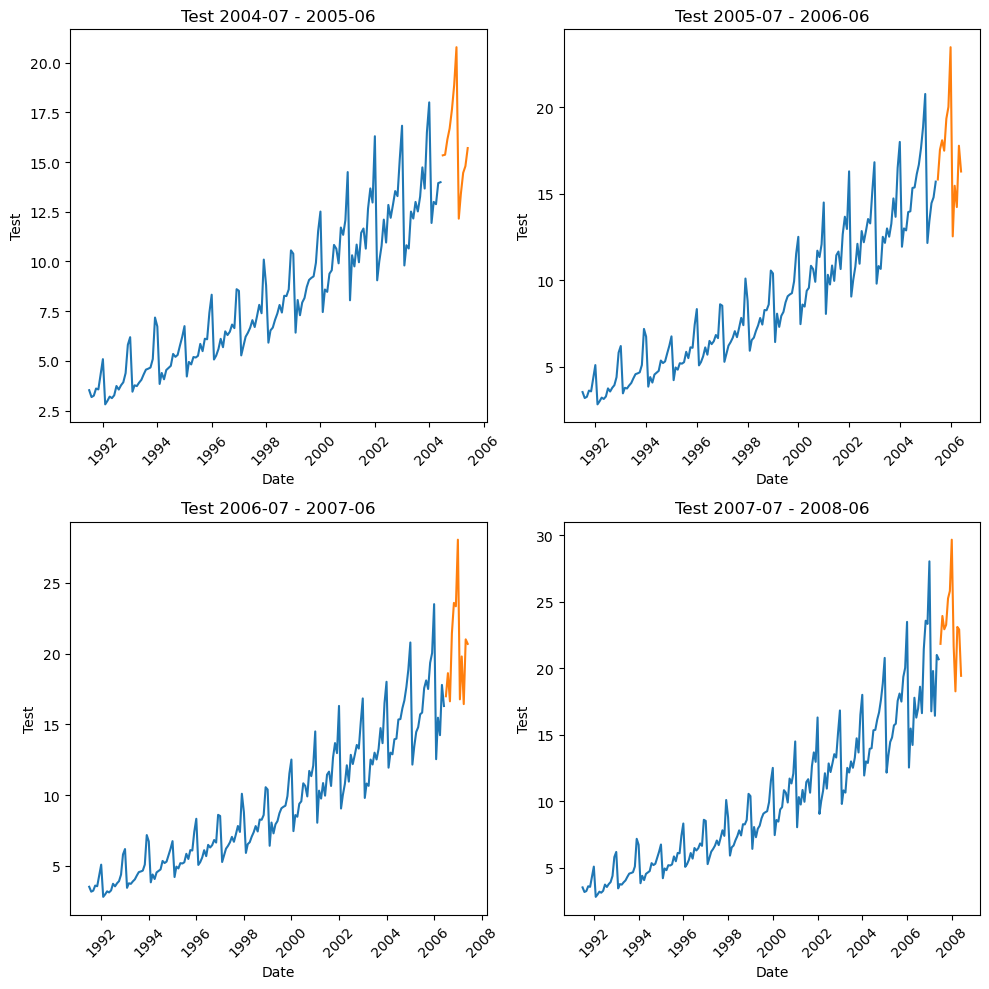

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

plot_ts(dfs[0][0], plot_col="value", ax=axes[0][0],title = "Test {} - {}".format(test_time_periods[0][1],test_time_periods[0][-1]))
plot_ts(dfs[0][1], plot_col="Test", ax=axes[0][0],title = "Test {} - {}".format(test_time_periods[0][1],test_time_periods[0][-1]))

plot_ts(dfs[1][0], plot_col="value",  ax=axes[0][1],title = "Test {} - {}".format(test_time_periods[1][1],test_time_periods[1][-1]))
plot_ts(dfs[1][1], plot_col="Test",  ax=axes[0][1],title = "Test {} - {}".format(test_time_periods[1][1],test_time_periods[1][-1]))


plot_ts(dfs[2][0],plot_col="value",ax=axes[1][0],title = "Test {} - {}".format(test_time_periods[2][1],test_time_periods[2][-1]))
plot_ts(dfs[2][1],plot_col="Test",ax=axes[1][0],title = "Test {} - {}".format(test_time_periods[2][1],test_time_periods[2][-1]))

plot_ts(dfs[3][0],plot_col="value",ax=axes[1][1],title = "Test {} - {}".format(test_time_periods[3][1],test_time_periods[3][-1]))
plot_ts(dfs[3][1],plot_col="Test",ax=axes[1][1],title = "Test {} - {}".format(test_time_periods[3][1],test_time_periods[3][-1]))
plt.tight_layout()
plt.show()

## ACF and PACF Plots

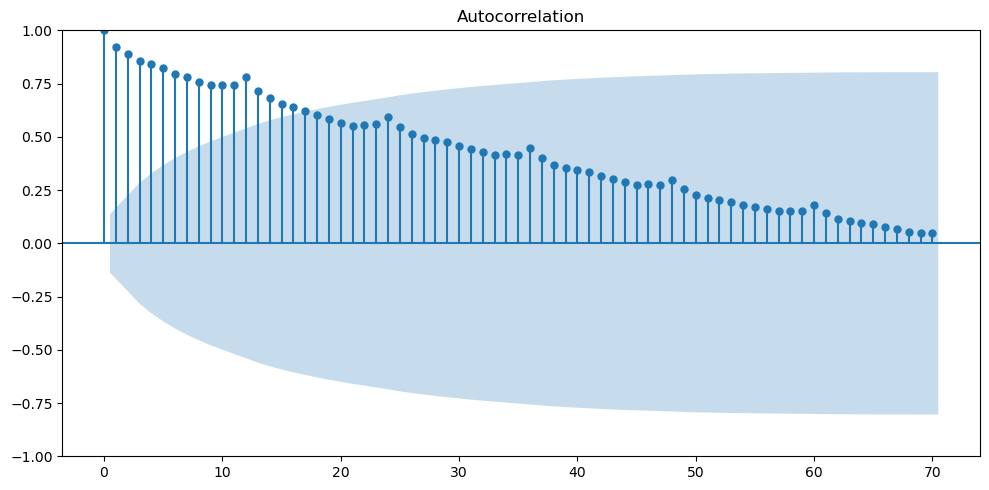

In [9]:
fig = plot_acf(data['value'], lags=70)
fig.set_size_inches((10, 5))
fig.tight_layout()
plt.show()

In [10]:
diff_df = data.diff().dropna()
seasonal_diff_train_df = diff_df.diff(12).dropna()

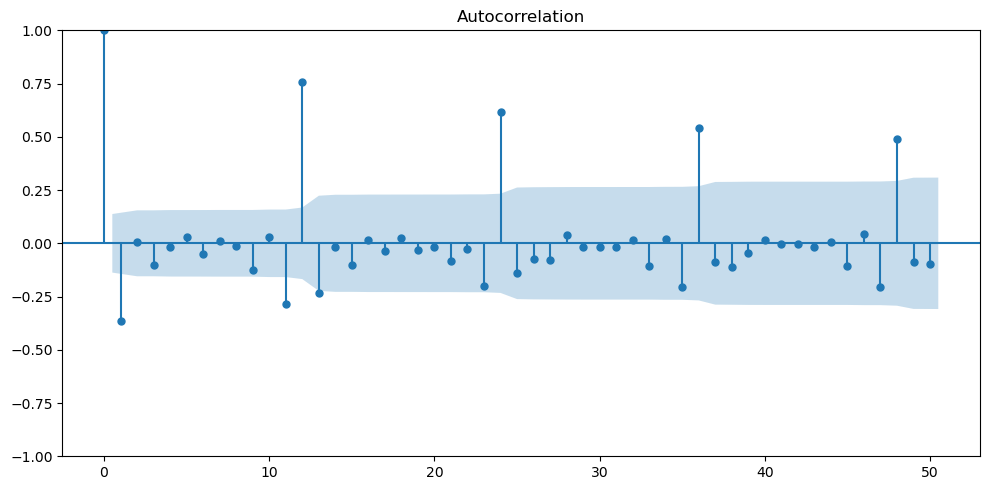

In [11]:

# autocorrelation plot of the seasonaly differenced dataset
fig = plot_acf(diff_df, lags=50)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

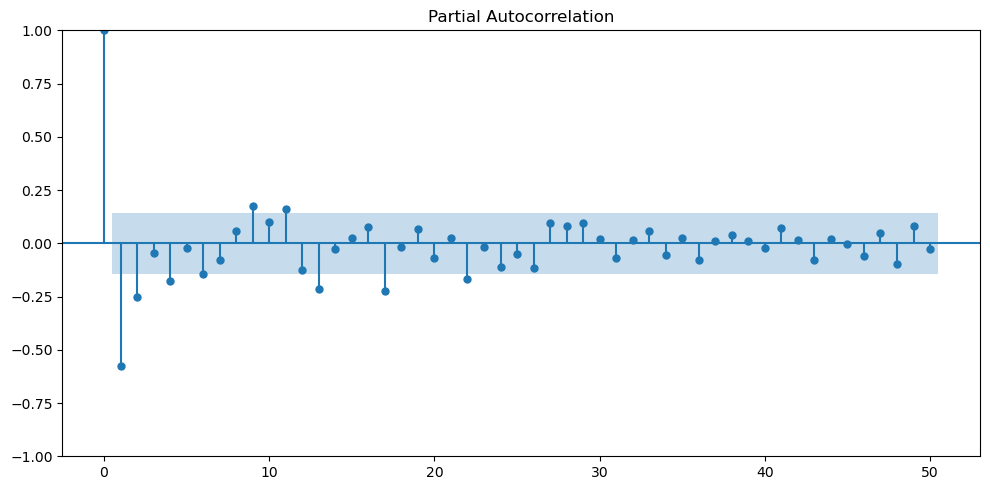

In [12]:

# autocorrelation plot of the seasonaly differenced dataset
fig = plot_pacf(seasonal_diff_train_df, lags=50)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

## ETS and Arima Models

In [13]:
def models(train_data,model_params = None):
    if model_params is None:
        model_params = {
            "ses" : {"smoothing_level":0.7},
            "des" : {"trend":"mul"},
            "tes" : {"trend":"mul", "seasonal":"mul","seasonal_periods":12}
        }


    # Points to predict
    pts_to_pred = 12

    # Simple Exponential Smoothing - No trend No seasonality
    ses = SimpleExpSmoothing(train_data).fit(smoothing_level=model_params["ses"]["smoothing_level"],optimized=False)
    ses_forecast = ses.forecast(pts_to_pred)

    # Double Exponential Smoothing / Holts Exponential Smoothing - Trend but No seasonality
    des = ExponentialSmoothing(train_data, trend=model_params["des"]["trend"]).fit()
    des_forecast = des.forecast(pts_to_pred)

    # Triple Exponential Smoothing - Winters Exponential Smoothing - Trend and Seasonality
    tes = ExponentialSmoothing(train_data,trend = model_params["tes"]["trend"],seasonal=model_params["tes"]["seasonal"],seasonal_periods=model_params["tes"]["seasonal_periods"]).fit()
    tes_forecast = tes.forecast(pts_to_pred)

    # Make series stationary
    train_diff_df = train_data.diff().dropna()
    seasonal_diff_train_df = train_diff_df.diff(12).dropna()

    # Auto Arima Manual Vals - ACF and PACF Plots (2,1,1)
    non_seasonal_manual_model = pm.arima.ARIMA(order = (2,1,1), seasonal_order = (0,0,0,12), suppress_warnings=True)
    non_seasonal_manual_model.fit(train_data)
    forecast_non_seasonal_manual = non_seasonal_manual_model.predict(n_periods=pts_to_pred, return_conf_int=False)

    # # Auto Arima Manual Vals - ACF and PACF Plots (2,1,1)
    seasonal_manual_model = pm.arima.ARIMA(order = (2,1,1), seasonal_order=(0,1,0,12),suppress_warnings=True) # - Check seasonal order once.
    seasonal_manual_model.fit(train_data)
    forecast_seasonal_manual = seasonal_manual_model.predict(n_periods=pts_to_pred, return_conf_int=False)

    # # Non Seasonal Auto Arima Auto Vals
    non_seasonal_auto_model = pm.auto_arima(train_data, start_p=0, start_q=0,test='adf', max_p=3, max_q=3, m=12, d=None, seasonal=False, trace=True,error_action='ignore', suppress_warnings=True, stepwise=True)
    forecast_non_seasonal_auto = non_seasonal_auto_model.predict(n_periods=pts_to_pred, return_conf_int=False)

    # # Seasonal Auto Arima Auto Vals
    seasonal_auto_model = pm.auto_arima(train_data, start_p=1, start_q=1, test='adf', max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=None, D=1, trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)
    forecast_seasonal_auto = seasonal_auto_model.predict(n_periods=pts_to_pred, return_conf_int=False)

    return ses_forecast,des_forecast,tes_forecast,forecast_non_seasonal_manual,forecast_seasonal_manual,forecast_non_seasonal_auto,forecast_seasonal_auto


In [14]:
forecast_labels = ["SES","DES","TES","Non Seasonal Manual Order","Seasonal Manual Order", "Non Seasonal Auto Order", "Seasonal Auto Order"]

In [15]:
forecasts_tp0 = models(dfs[0][0])
forecasts_tp1 = models(dfs[1][0])
forecasts_tp2 = models(dfs[2][0])
forecasts_tp3 = models(dfs[3][0])


/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/pmdarima/arima/_validation.py:62: UserWarn

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1123.692, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=598.075, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=961.453, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=565.571, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=558.166, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=560.084, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=566.735, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=558.602, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=578.474, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=558.613, Time=0.09 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 0.655 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=226.709, Time=0.16 se

/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: R

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1235.924, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=663.903, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1060.107, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=633.748, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=624.012, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=625.917, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=634.244, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=624.754, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=643.528, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=624.552, Time=0.09 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 0.694 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=277.978, Time=0.53 s

/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: R

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1350.798, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=750.098, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1165.103, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=711.946, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=703.384, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=705.294, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=710.434, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=705.089, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=695.975, Time=0.13 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=695.569, Time=0.17 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=695.085, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=704.127, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=697.919, Ti

/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/amhaskar/miniconda3/envs/test_pytorch/lib/python3.9/site-packages/pmdarima/arima/_validation.py:62: UserWarn

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1473.879, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=844.283, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1279.130, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=802.660, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=794.855, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=795.190, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=799.333, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=797.769, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=785.896, Time=0.14 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=792.088, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=788.158, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=788.574, Time=0.18 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total 

## Backtesting and Plots

In [16]:
# Function to calculate Errors
def calc_errors(truth = np.array([[1,1]]),forecasts = np.array([[1,1]])):
    errors = []
    for forecast in forecasts:
        errors.append(mean_squared_error(truth,np.array(forecast)))
    return errors

SES RMSE: 9.27198188654822
DES RMSE: 5.817135539661087
TES RMSE: 0.38458870996737876
Non Seasonal Manual Order RMSE: 7.68407125026004
Seasonal Manual Order RMSE: 1.2426995488031398
Non Seasonal Auto Order RMSE: 10.189294658371544
Seasonal Auto Order RMSE: 1.317661841014575


<Figure size 2000x1000 with 0 Axes>

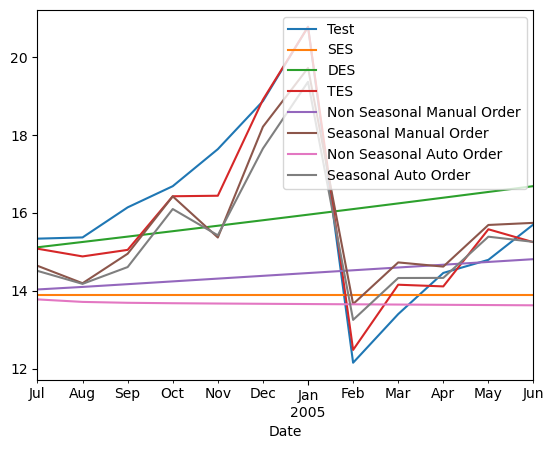

In [17]:
errors = calc_errors(dfs[0][1].Test,forecasts_tp0)
for ind in range(len(forecast_labels)):
    print(forecast_labels[ind],"RMSE:",errors[ind])
    dfs[0][1][forecast_labels[ind]] = forecasts_tp0[ind]

plt.figure(figsize=(20, 10))
# ax = dfs[0][0]["value"].plot(label = "Train")
dfs[0][1].plot()

plt.xlabel('Date')
plt.legend()
plt.show()

SES RMSE: 11.316420391420026
DES RMSE: 8.50549884264242
TES RMSE: 0.874909928406641
Non Seasonal Manual Order RMSE: 9.465427770100595
Seasonal Manual Order RMSE: 0.937156017246994
Non Seasonal Auto Order RMSE: 11.6553069703402
Seasonal Auto Order RMSE: 1.3331824154065461


<Figure size 2000x1000 with 0 Axes>

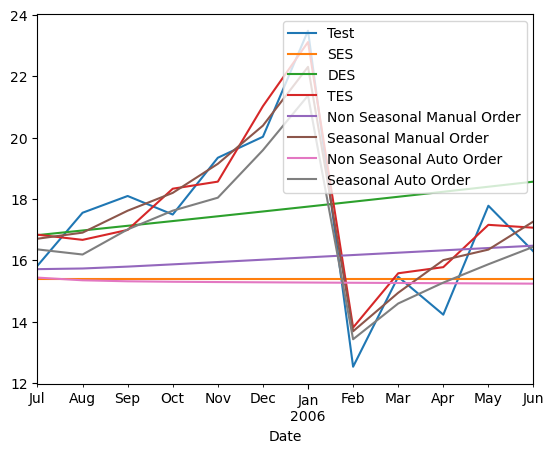

In [18]:
errors = calc_errors(dfs[1][1].Test,forecasts_tp1)
for ind in range(len(forecast_labels)):
    print(forecast_labels[ind],"RMSE:",errors[ind])
    dfs[1][1][forecast_labels[ind]] = forecasts_tp1[ind]

plt.figure(figsize=(20, 10))
# ax = dfs[0][0]["value"].plot(label = "Train")
dfs[1][1].plot()

plt.xlabel('Date')
plt.legend()
plt.show()

SES RMSE: 25.987986041801136
DES RMSE: 12.140822364121364
TES RMSE: 4.073329997938628
Non Seasonal Manual Order RMSE: 18.47211276252051
Seasonal Manual Order RMSE: 5.058283500806971
Non Seasonal Auto Order RMSE: 23.812247758233426
Seasonal Auto Order RMSE: 6.838538086904092


<Figure size 2000x1000 with 0 Axes>

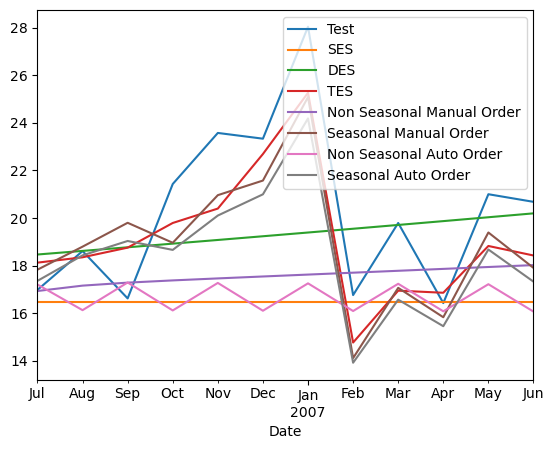

In [19]:
errors = calc_errors(dfs[2][1].Test,forecasts_tp2)
for ind in range(len(forecast_labels)):
    print(forecast_labels[ind],"RMSE:",errors[ind])
    dfs[2][1][forecast_labels[ind]] = forecasts_tp2[ind]

plt.figure(figsize=(20, 10))
# ax = dfs[0][0]["value"].plot(label = "Train")
dfs[2][1].plot()

plt.xlabel('Date')
plt.legend()
plt.show()

SES RMSE: 15.398449747061155
DES RMSE: 10.880837420892142
TES RMSE: 3.9928398213757874
Non Seasonal Manual Order RMSE: 16.713579957369124
Seasonal Manual Order RMSE: 6.459354970822125
Non Seasonal Auto Order RMSE: 18.160985180697235
Seasonal Auto Order RMSE: 5.459681964439016


<Figure size 2000x1000 with 0 Axes>

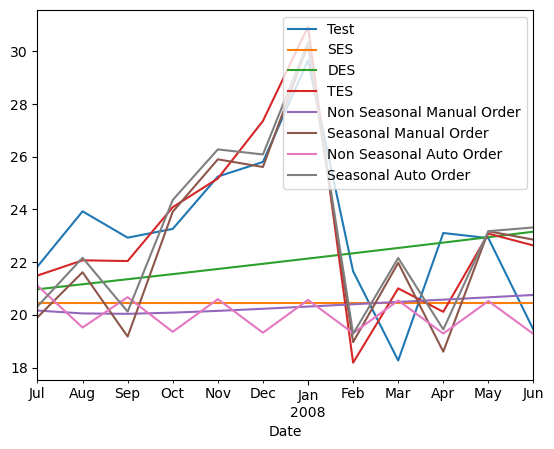

In [20]:
errors = calc_errors(dfs[3][1].Test,forecasts_tp3)
for ind in range(len(forecast_labels)):
    print(forecast_labels[ind],"RMSE:",errors[ind])
    dfs[3][1][forecast_labels[ind]] = forecasts_tp3[ind]

plt.figure(figsize=(20, 10))
# ax = dfs[0][0]["value"].plot(label = "Train")
dfs[3][1].plot()

plt.xlabel('Date')
plt.legend()
plt.show()

## Result Comparison

### Comparison based on plots and RMSE values.
    Examining the aforementioned plots and RMSE values leads us to the conclusion that TES models appear to outperform others in capturing the pattern in this scenario. Following closely are Seasonal ARIMA models, where we rely on the auto ARIMA algorithm to determine the order for trend and seasonality components. So based on the available data if I wanted to make predictions for next 12 months I would use the TES model.

### Conclusion
    The decision between ETS and ARIMA relies on multiple factors, with neither method universally outperforming the other. ETS models demonstrate particular effectiveness in handling data with both trend and seasonality, making them well-adapted for capturing intricate patterns. Conversely, ARIMA models excel in capturing patterns within more stationary series. Although differencing can enhance performance, it does not fully compensate for the superior ability of ETS models in representing trend and seasonality.